In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, collections
from scipy.stats import boxcox

class ListingsPreprocessing:
    
    # Init
    def __init__(self, path):
        self.path = path

    # Load data
    def load(self):
        return pd.read_csv(self.path, low_memory=False)

    # Get attributes from l
    def get_attributes(self, l):
        return [(i, l.columns[i]) for i in range(len(l.columns))]

    # Prune unusable attributes
    def prune_attributes(self, l):
        l = l.dropna(how = 'any', subset = ['id','last_scraped','host_since','neighbourhood_cleansed',
        'latitude','longitude','property_type','room_type','accommodates','bathrooms',
        'bedrooms','beds','bed_type','amenities','price','cleaning_fee',
        'guests_included', 'extra_people','availability_30', 'availability_60', 'availability_90',
        'availability_365', 'first_review', 'last_review','minimum_nights','maximum_nights',
        'number_of_reviews','cancellation_policy'])
        for x in ['beds','bedrooms','bathrooms','price','accommodates']:
            l = l[l[x]!=0]
        l = l.reset_index(drop=True)
        for x in ['price','cleaning_fee','extra_people']:
            l[x] = l[x].str.replace(r'[^-+\d.]', '').astype(float)
        for x in ['last_scraped','host_since','first_review', 'last_review']:
            l[x] = pd.to_datetime(l[x])
        l.loc[l['maximum_nights']>2000,'maximum_nights']=2000
        l['no_reviews'] = 0
        l.loc[l['review_scores_rating']!=l['review_scores_rating'],['review_scores_rating','no_reviews']]=0,1
        return l

    # Encode categorical attributes
    def encode_cat(self, l):
        #for i in range(len(l)):
        #    if l.loc[i, 'review_scores_accuracy'] != l.loc[i, 'review_scores_accuracy']:
        #        l.loc[i, 'review_scores_accuracy'] = 'No Review'

        categorical_attributes = ['neighbourhood_cleansed', 
                              'property_type',
                              'room_type',
                              'bed_type',
                              #'review_scores_accuracy',
                              'cancellation_policy']

        for attr in categorical_attributes:
            encoded_cols = pd.get_dummies(l[attr])
            l = pd.concat((l.drop(attr, axis = 1), encoded_cols), axis = 1)

        return l

    # Standardize float attributes
    def standardize(self, col):
        mean = np.mean(col)
        std = np.std(col)
        return col.apply(lambda x: (x - mean) / std)
    
    #another normalize function   
    def normalize(sef,col):
        newcol,la = boxcox(col)
        min_ = newcol.min()
        dif_ = newcol.max()-min_
        return (newcol-min_)/dif_
    
    # Encode uncategorical attributes
    def encode_uncat(self, l):
        noncategorical_attributes = ['host_since', 'accommodates', 
                                 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews','review_scores_rating', 'cleaning_fee',
                                   'guests_included', 'extra_people','availability_30', 'availability_60', 'availability_90',
                                   'availability_365', 'first_review', 'last_review',
                                'minimum_nights', 'maximum_nights','latitude','longitude']
        dtattr = ['host_since','first_review', 'last_review']
        for attr in noncategorical_attributes:
            #if attr == 'host_since':
                #l[attr] = self.standardize(l[attr].str.replace(r'-', '').astype(float))
            #else:
                #l[attr] = self.standardize(l[attr].astype(float))
            print(attr)
            if attr in dtattr:
                min_ = l[attr].min()
                l[attr] = l[attr]-min_
                l[attr] = l[attr].apply(lambda x: x.days)
            elif attr=='longitude':
                min_ = l[attr].min()
                l[attr] = l[attr]-min_
            print(attr,sorted(l[attr])[:10])
            l[attr] = self.normalize(l[attr]+1)
            print(sorted(l[attr])[:5],sorted(l[attr])[-5:])
        return l

    # Extract features from amenities
    def count_amenities(self, l):
        numa = 20
        def reformat(col):
            return col.apply(lambda x: x.strip('{}').replace('"','').split(','))

        def sort_by_value(d): 
            items=d.items() 
            backitems=[[v[1],v[0]] for v in items] 
            backitems.sort(reverse=True) 
            return [ backitems[i][1] for i in range(0,len(backitems))] 

        l['amenities'] = reformat(l['amenities'])
        amenity_lists = []
        for j in range(len(l)):
            amenity_lists.extend(l.loc[j, 'amenities'])
        frequency = collections.defaultdict(int)

        for amenity in amenity_lists: 
            frequency[amenity] += 1
        amenities_picked = sort_by_value(frequency)[0:numa]
        new_cols = pd.DataFrame(columns = amenities_picked, data = list(np.zeros((len(l), numa))), dtype=int)

        for j in range(len(new_cols)):
            for i in range(numa):
                if amenities_picked[i] in l.amenities[j]:
                    new_cols.iloc[j,i] += 1
        l = pd.concat((l.drop('amenities', axis=1),new_cols), axis=1)

        return l

    # Clean data
    def clean(self, l, attr):
        l_info = ['id',
        'last_scraped',
        'host_since',
        'neighbourhood_cleansed',
        'latitude',
        'longitude',
        'property_type',
        'room_type',
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'bed_type',
        'amenities',
        'price',
        'cleaning_fee',
        'guests_included', 
        'extra_people',
        'availability_30',
        'availability_60',
        'availability_90',
        'availability_365', 
        'first_review', 
        'last_review',
        'minimum_nights',
        'maximum_nights',
        'number_of_reviews',
        'review_scores_rating',
        #'review_scores_accuracy',
        'cancellation_policy']

        l = l[l_info].copy()
        l = self.prune_attributes(l)
        return l

    # Extract features
    def extract_feature(self, l):
        l = self.encode_cat(l)
        l = self.encode_uncat(l)
        l = self.count_amenities(l)
        return l

    # Preprocessing listings
    def do_preprocessing(self, operation='extraction'):
        raw_l = self.load()
        attributes = self.get_attributes(raw_l)
        l = self.clean(raw_l, attributes)
        if operation == 'extraction':
            l = self.extract_feature(l)
        elif operation == 'clean':
            pass
        else:
            raise ValueError('Operation can only be clean or extraction!')
        return l

In [ ]:
import glob
folders = sorted(glob.glob('../data/2*'))
def merge_df(folders):
    mergedf = pd.concat([clean_calendar(f+'/calendar.csv') for f in folders],sort=False)
    mergedf.drop_duplicates(subset=['listing_id','date'], keep='last', inplace=True)
    #pricedf = mergedf.groupby(by='date')['price'].mean().reset_index()
    #countlisting = mergedf.groupby(by='listing_id')['price'].count().reset_index()
    #countlisting.sort_values(by=['price'],ascending=False)
    return mergedf
def price_df(df):
    pricedf = df.groupby(by='date')['price'].mean().reset_index()
    pricedf.plot(x='date',y='price',figsize=(20,4))
    return pricedf
def longlisting(df):
    #return the listing_id available for hundreds of days
    count_listing = df.groupby(by='listing_id')['price'].count().reset_index()\
                      .sort_values(by=['price'],ascending=False).reset_index(drop=True)
    return count_listing[:100]['listing_id'].values

In [19]:
fl ='../data/2018_04_14/listings.csv'

In [33]:

from dateutil.parser import parse
parse([x for x in fl.split('/') if x.startswith('20')][0].replace('_',''))

datetime.datetime(2018, 4, 14, 0, 0)

In [203]:
lb = ListingsPreprocessing(fl).do_preprocessing()

host_since
host_since [0, 38, 114, 137, 201, 212, 281, 281, 281, 325]
[0.0, 0.0029335781187083947, 0.011935675830167193, 0.015111666673388962, 0.02473539221853566] [0.9919805098734552, 0.9927089517690959, 0.9948950013276977, 0.9970821356756829, 1.0]
accommodates
accommodates [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 1.0, 1.0, 1.0, 1.0]
bedrooms
bedrooms [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0] [0.9898658591178049, 0.9898658591178049, 0.99624285130582, 0.99624285130582, 1.0]
beds
beds [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0] [0.9702095196026146, 0.9797061323954976, 0.9797061323954976, 0.987618430768725, 1.0]
bathrooms
bathrooms [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.0, 0.0, 0.0, 0.0, 0.0] [0.9991486742494722, 0.9994799956980973, 1.0, 1.0, 1.0]
number_of_reviews
number_of_reviews [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.0, 0.0, 0.0, 0.0, 0.0] [0.9582968765387309, 0.963513545032373, 0.9834

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: overflow encountered in square
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))


In [204]:
def myhist(l,attr):
    data = l[attr]
    plt.figure()
    plt.hist(data,bins=20)
    plt.title(attr)

In [205]:
cols =['host_since', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'number_of_reviews','cleaning_fee',
        'guests_included', 'extra_people','availability_30', 'availability_60', 'availability_90',
        'availability_365', 'first_review', 'last_review','review_scores_rating']

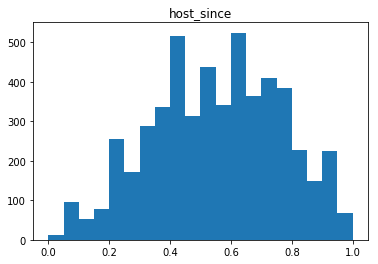

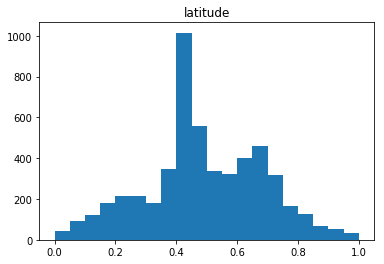

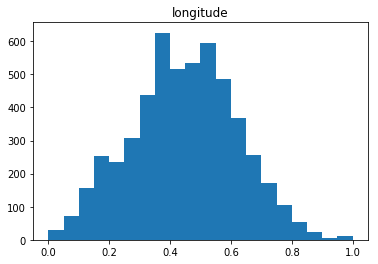

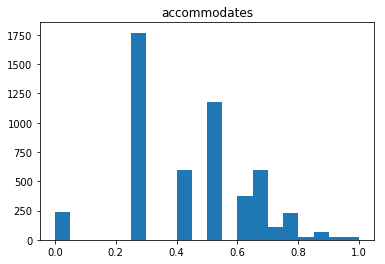

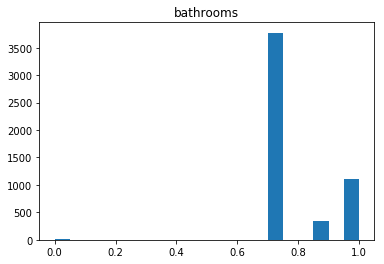

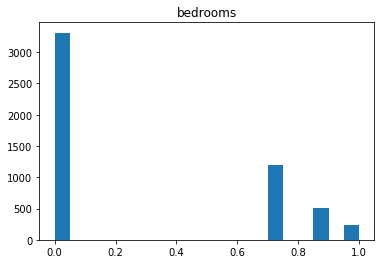

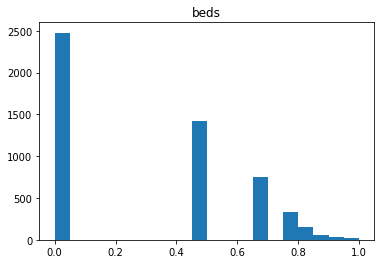

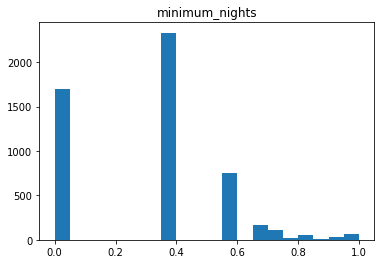

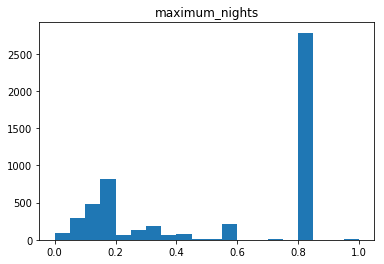

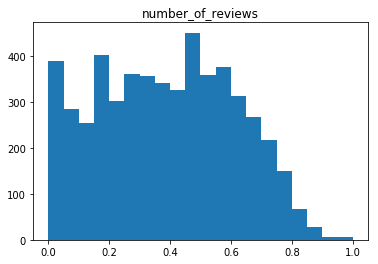

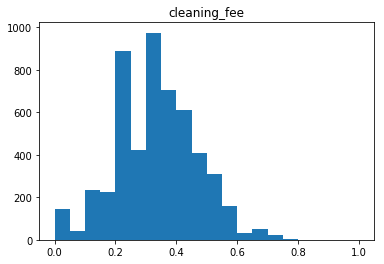

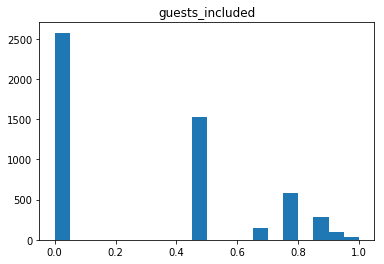

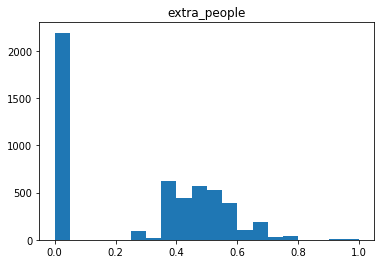

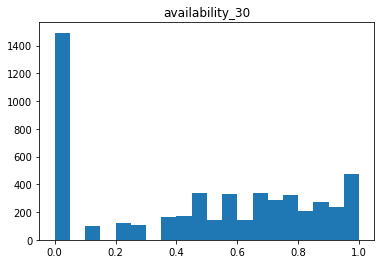

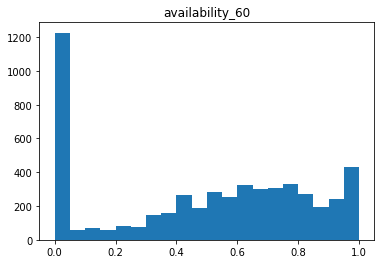

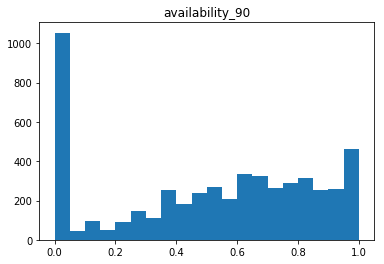

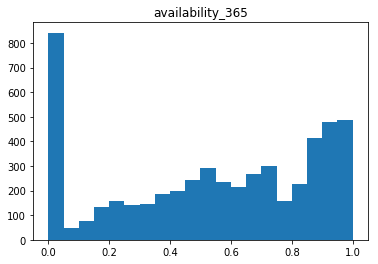

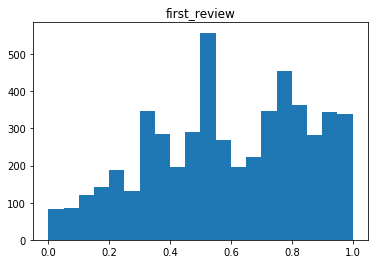

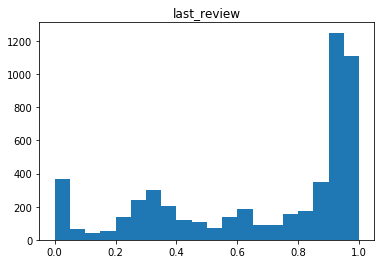

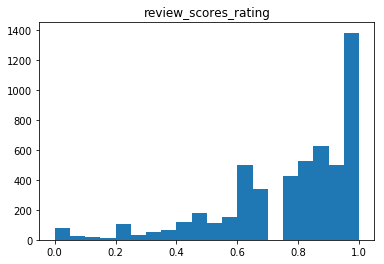

In [206]:
for i in cols:
    myhist(lb,i)

In [39]:
#dates = pd.to_datetime(pd.Series(['20010101', '20010331',None]), format = '%Y%m%d')
pd.to_datetime('20180401',format='%Y%m%d')

Timestamp('2018-04-01 00:00:00')

In [21]:
del ListingsPreprocessing

In [3]:
from python.listingspreprocessing import ListingsPreprocessing
import pandas as pd

In [4]:
df = pd.read_csv('../save/data_bc_first_addattr_scraped.csv')

In [9]:
df[df['days_from_scraped']<0]['days_from_scraped']

113        -3
114        -4
115        -5
116        -6
117        -9
118       -18
119       -19
120       -20
121       -21
122       -22
123       -52
124       -53
125       -54
126       -62
127       -63
128       -64
129       -65
130       -78
131       -79
132       -80
133       -81
134       -82
135       -83
136       -84
323       -13
491       -13
492       -50
595       -17
596       -18
597       -19
           ..
1109273   -22
1109274   -21
1109275   -20
1109276   -18
1109277   -17
1109278   -12
1109293   -19
1109385   -23
1109386   -22
1109387   -21
1109388   -20
1109389   -18
1109390   -17
1109391   -12
1109406   -19
1109498   -23
1109499   -22
1109500   -21
1109501   -20
1109502   -18
1109503   -17
1109504   -12
1109519   -19
1109611   -23
1109612   -22
1109613   -21
1109614   -20
1109615   -18
1109616   -17
1109617   -12
Name: days_from_scraped, Length: 91570, dtype: int64

In [6]:
ListingsPreprocessing('n').int_date(df['days_from_scraped'])#normalize(df['days_from_scraped'])

AttributeError: Can only use .dt accessor with datetimelike values

In [25]:
import datetime, calendar
import pandas as pd
from dateutil.parser import parse

class DatePreprocessing:
    def __init__(self, path):
        self.path = path
        self.holidays = ['NewYear','MartinLK','President','Memorial','Independence','Labor','Columbus','Veterans','Thanksgiving','Christmas']
        self.week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
        self.month =  ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        self.year = [2018,2019]


    def holiday(self, year):
        #fixed holidays
        fixmd = [[1,1],[7,4],[11,11],[12,25]]
        holidays = [datetime.datetime(year,x[0],x[1]) for x in fixmd]
        #floating holidays
        #'2,3,1': the third Monday of Feburary;'5,-1,1': the last Monday of May 
        floatmwd = ['1,3,1','2,3,1','5,-1,1','9,1,1','10,2,1','11,4,4']
        holidays.extend([self.flholiday(year,x) for x in floatmwd])
        return sorted(holidays)

    def flholiday(self, y,mwd):
        #input year and month-week-weekday
        m,w,d = list(map(int,mwd.split(',')))
        d = d-1
        wday, mrange = calendar.monthrange(y, m) #firstDayWeekDay,monthRange
        if w>0:
            if wday<=d:
                day = 1+7*(w-1)+d-wday
            else:
                day = 1+7*w-(wday-d)
        else:
            wday = datetime.datetime(y,m,mrange).weekday()
            if d<=wday:
                day = mrange+7*(w+1)-(wday-d)
            else:
                day = mrange+7*w+(d-wday)
        return datetime.datetime(y,m,day)

    def load(self):
        df = self.clean_calendar()
        return df

    def clean_calendar(self):
        df = pd.read_csv(self.path).dropna().drop(columns='available').reset_index(drop=True)
        df = df[['listing_id','date','price']] #only keep these three columns
        df['price'] =  df['price'].apply(lambda x: x.replace('$','').replace(',','')).astype('float')
        df['date'] = pd.to_datetime(df['date'])
        df = self.add_scraped(df)
        return df

    def add_weeks(self, df):
        #day of week
        week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
        df['week'] = df.date.dt.dayofweek
        for i,w in enumerate(self.week):
            df[w]=0
            df.loc[df['week']==i,w]=1
        #df['FriSat'] = df.apply(lambda x: int(x['week']==4 or x['week']==5),axis=1)
        return df

    def add_months(self, df):
        # month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        for i,m in enumerate(self.month):
            df[m]=0
            df.loc[df.date.dt.month==i+1,m]=1
        return df

    def add_weather(self,df):
        weather = pd.read_excel('./seattle_weather.xlsx').values
        df['aveT'] = 0
        df['precipitation'] = 0
        for i,m in enumerate(self.month):
            df.loc[df[m]==1,['aveT','precipitation']]=weather[i]
        return df

    def add_years(self, df):
        # year = [2018,2019]
        for y in self.year:
            df[y]=0
            df.loc[df.date.dt.year==y,y]=1
        return df

    def add_christmas_holidays(self, df):
        df['ChristmasHolidays']=0
        df.loc[(df.date.dt.month==12) & (df.date.dt.day>=25),'ChristmasHolidays']=1
        return df

    def add_other_holidays(self, df):
        # holidays = ['NewYear','MartinLK','President','Memorial','Independence','Labor','Columbus','Veterans','Thanksgiving']
        holiday18 = self.holiday(2018)
        holiday19 = self.holiday(2019)
        for i,h in enumerate(self.holidays):
            df[h]=0
            df.loc[df.date==holiday18[i],h]=1
            df.loc[df.date==holiday19[i],h]=1
        return df

    def add_scraped(self,df):
        scraped = parse([x for x in self.path.split('/') if x.startswith('20')][0].replace('_',''))
        df['days_from_scraped'] = (df['date']-scraped).dt.days
        #df['days_from_scraped'] = ListingsPreprocessing('na').normalize(df['days_from_scraped']+1)
        return df
    
    def get_average(self, df):
        myholi = ['ChristmasHolidays']
        myholi.extend(self.holidays)
        df_nholi = df[(df[myholi]==0).all(axis=1)].drop(columns=myholi)

        gmark = ['listing_id']
        gmark.extend(self.year)
        gmark.extend(self.month)
        gmark.extend(self.week)

        result = df_nholi.groupby(gmark)['price'].mean().to_frame()
        result.reset_index(inplace=True)
        df_holi = df[(df[myholi]==1).any(axis=1)]
        df = pd.concat([df_holi,result],ignore_index=True,sort=False).fillna(0)
        return df


    def drop_dupweek(self,df):
        myholi = self.holidays
        myholi.append('ChristmasHolidays')
        df_holi = df[(df[myholi]==1).any(axis=1)].copy()
        df_nholi = df[(df[myholi]==0).all(axis=1)].copy()

        df_nholi['ym'] = df_nholi['date'].dt.strftime('%y%m')
        mark = ['listing_id','week','ym']
        df_nholi.drop_duplicates(subset=mark,keep='first',inplace=True)
        df_nholi.drop(columns='ym',inplace=True)
        df = pd.concat([df_holi,df_nholi],ignore_index=True,sort=False)
        return df

    def extract_feature(self, df):

        df = self.add_weeks(df)
        #df = self.add_christmas_holidays(df)
        df = self.add_other_holidays(df)
        #df = self.get_average(df)
        #df = self.drop_dupweek(df)   
        df = self.add_months(df)
        df = self.add_years(df)
        df = self.add_weather(df)
        df = df.drop(columns=['week','date'])
        return df


    def do_preprocessing(self):
        df = self.load()
        df = self.extract_feature(df)
        #df = df.drop(columns=['week','date'])
        #df = df.drop(columns=self.week)
        return df
                                                                                                           

In [26]:
df = DatePreprocessing('../data/2018_04_14/calendar.csv').do_preprocessing()

In [27]:
df

,listing_id,price,days_from_scraped,Mon,Tue,Wed,Thu,Fri,Sat,Sun,...,Jul,Aug,Sep,Oct,Nov,Dec,2018,2019,aveT,precipitation
0,23883355,120.0,85,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,65.45,0.93
1,23883355,118.0,81,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,65.45,0.93
2,23883355,118.0,80,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,65.45,0.93
3,23883355,118.0,79,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,65.45,0.93
4,23883355,118.0,78,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,65.45,0.93
5,23883355,129.0,77,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,61.10,1.55
6,23883355,129.0,76,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,61.10,1.55
7,23883355,110.0,75,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,61.10,1.55
8,23883355,110.0,74,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,61.10,1.55
9,23883355,110.0,73,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,61.10,1.55


In [42]:
from dateutil.parser import parse
scraped = parse([x for x in fl.split('/') if x.startswith('20')][0].replace('_',''))


In [37]:
df = pd.read_csv('../data/2018_04_14/calendar.csv')

In [41]:
df['date'] = pd.to_datetime(df['date'])